In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
pd.set_option('display.max_rows', 300)

In [3]:
df = pd.read_csv("ms-pv-2006/Actual_30.25_-89.45_2006_UPV_118MW_5_Min.csv")

In [4]:
df['Datetime'] = pd.to_datetime(df['LocalTime'], format='%m/%d/%y %H:%M')
df.set_index('Datetime', inplace=True)

In [5]:
dff = df['Power(MW)']
df

,LocalTime,Power(MW)
Datetime,,
2006-01-01 00:00:00,01/01/06 00:00,0.0
2006-01-01 00:05:00,01/01/06 00:05,0.0
2006-01-01 00:10:00,01/01/06 00:10,0.0
2006-01-01 00:15:00,01/01/06 00:15,0.0
2006-01-01 00:20:00,01/01/06 00:20,0.0
...,...,...
2006-12-31 23:35:00,12/31/06 23:35,0.0
2006-12-31 23:40:00,12/31/06 23:40,0.0
2006-12-31 23:45:00,12/31/06 23:45,0.0


In [6]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")

In [7]:
adf_test(dff)

ADF Statistic: -39.028619911556035
p-value: 0.0
Series is stationary


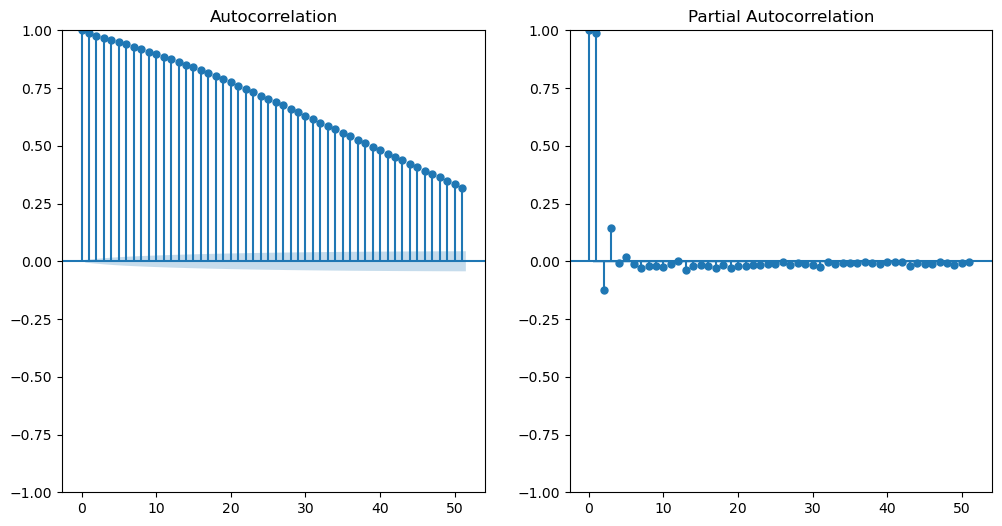

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(dff, ax=plt.gca())
plt.subplot(122)
plot_pacf(dff, ax=plt.gca())
plt.show()

In [9]:
df['PowerDiff'] = dff.diff().dropna()
diff = df['PowerDiff']

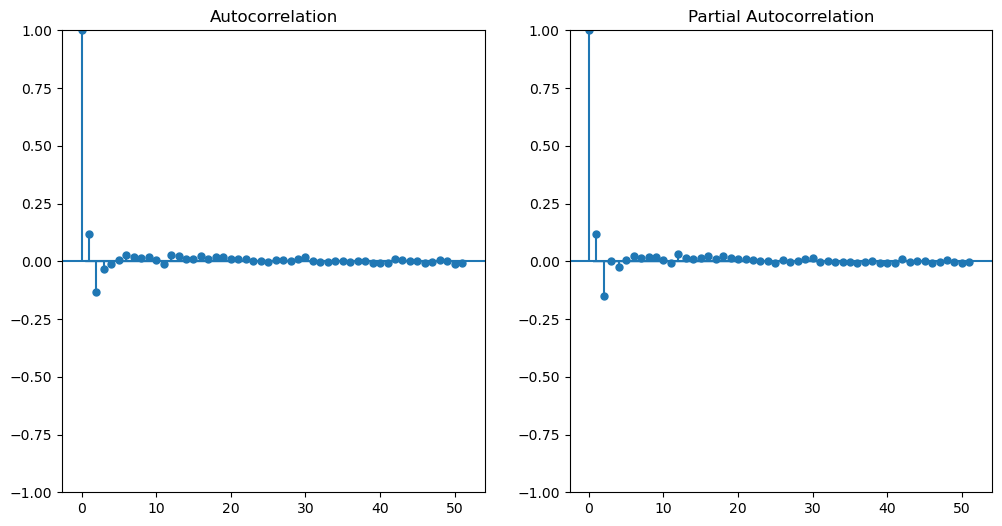

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(diff.dropna(), ax=plt.gca())  # ACF for 'q'
plt.subplot(122)
plot_pacf(diff.dropna(), ax=plt.gca())  # PACF for 'p'
plt.show()

In [30]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

def evaluate_arima_model(X, arima_order):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit()
    return model_fit.aic


def grid_search_arima(data, p_values, d_values, q_values):
    best_aic = float("inf")
    best_order = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    aic = evaluate_arima_model(data, (p,d,q))
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                except:
                    continue
    return best_order


p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)


best_order = grid_search_arima(dff, p_values, d_values, q_values)
print(f'Best ARIMA order: {best_order}')

Best ARIMA order: (2, 0, 2)


In [31]:
train_size = int(len(df) * 0.8)
train, test = dff[:train_size], dff[train_size:]

In [32]:
best_p, best_d, best_q = best_order
model = ARIMA(train, order=(best_p, best_d, best_q))
model_fit = model.fit()


predictions = model_fit.forecast(steps=len(test))


mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 25.928171333401718


In [33]:
print(predictions[:500:5])
print(f"Test set length: {len(test)}, Predictions length: {len(predictions)}")

2006-10-20 00:00:00     0.242440
2006-10-20 00:25:00     1.427566
2006-10-20 00:50:00     2.508005
2006-10-20 01:15:00     3.536382
2006-10-20 01:40:00     4.515222
2006-10-20 02:05:00     5.446909
2006-10-20 02:30:00     6.333717
2006-10-20 02:55:00     7.177806
2006-10-20 03:20:00     7.981234
2006-10-20 03:45:00     8.745961
2006-10-20 04:10:00     9.473850
2006-10-20 04:35:00    10.166675
2006-10-20 05:00:00    10.826127
2006-10-20 05:25:00    11.453812
2006-10-20 05:50:00    12.051261
2006-10-20 06:15:00    12.619930
2006-10-20 06:40:00    13.161206
2006-10-20 07:05:00    13.676409
2006-10-20 07:30:00    14.166793
2006-10-20 07:55:00    14.633555
2006-10-20 08:20:00    15.077833
2006-10-20 08:45:00    15.500709
2006-10-20 09:10:00    15.903215
2006-10-20 09:35:00    16.286332
2006-10-20 10:00:00    16.650994
2006-10-20 10:25:00    16.998089
2006-10-20 10:50:00    17.328465
2006-10-20 11:15:00    17.642926
2006-10-20 11:40:00    17.942240
2006-10-20 12:05:00    18.227135
2006-10-20

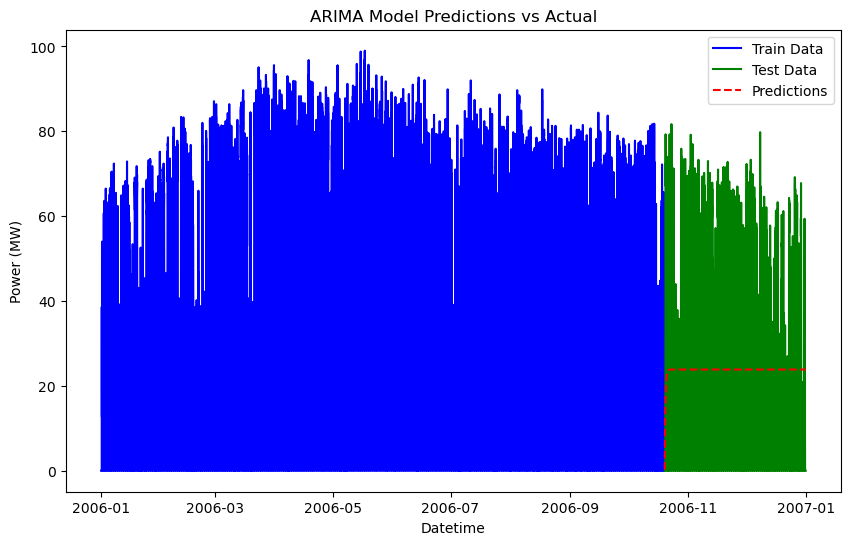

In [34]:
plt.figure(figsize=(10,6))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(test.index, predictions, label='Predictions', color='red', linestyle='--')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Power (MW)')
plt.title('ARIMA Model Predictions vs Actual')
plt.show()

In [35]:
future_steps = 30
forecast = model_fit.forecast(steps=future_steps)

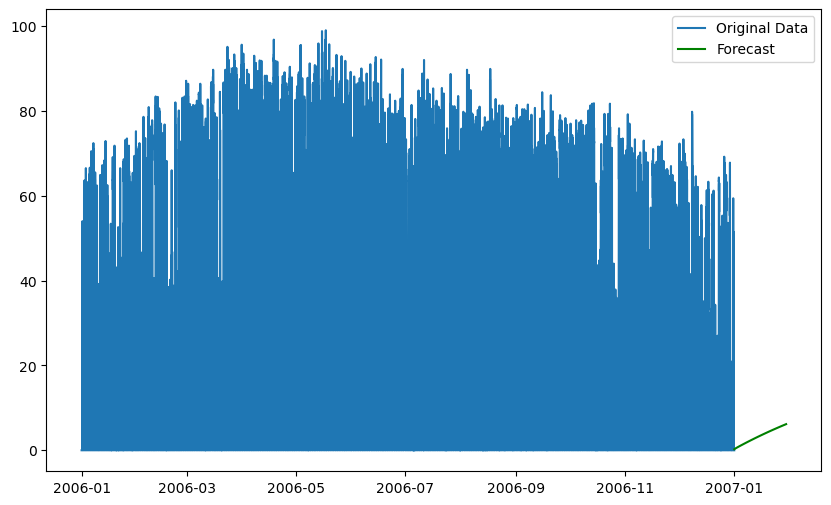

In [48]:
plt.figure(figsize=(10,6))
plt.plot(df.index, dff, label='Original Data')  # Replace 'Value' with correct column name
plt.plot(pd.date_range(df.index[-1], periods=future_steps, freq='D'), forecast, label='Forecast', color='green')
plt.legend()
plt.show()